In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as Pickle
import spacy
import random

from fastai.structured import *
from fastai.column_data import *

In [2]:
bs,bptt = 64,70

## Language modeling

### Data

In [3]:
import pandas as pd

In [4]:
PATH='data/high-flyers/'

df_tweets = pd.read_csv(f'{PATH}train.csv', index_col=0)
df_test = pd.read_csv(f'{PATH}test.csv', index_col=0)

In [5]:
from IPython.display import HTML, display
display(df_tweets.head())

,text,airline,tweet_location,user_timezone,sentiment
id,,,,,
0,@JetBlue great flight! Great view! :-) http://...,Delta,NaN,NaN,positive
1,"@united they're not, actually. gate agent was ...",United,chicago,NaN,negative
2,@AmericanAir No worries they called back 4 hrs...,American,"Dallas, Texas",NaN,negative
3,@united thank you. There was one here a few mo...,United,"New York, NY",America/New_York,positive
4,@united Brothers luggage was lost on Copa Airl...,United,"Kearney, Nebraska",Central Time (US & Canada),negative


In [6]:
display(DataFrameSummary(df_tweets).summary())

,text,airline,tweet_location,user_timezone,sentiment
count,10387,10387,6972,6901,10387
unique,10258,6,2429,76,2
top,@JetBlue thanks!,United,"Washington, DC",Eastern Time (US & Canada),negative
freq,5,2822,120,2673,8242
counts,10387,10387,6972,6901,10387
uniques,10258,6,2429,76,2
missing,0,0,3415,3486,0
missing_perc,0%,0%,32.88%,33.56%,0%
types,categorical,categorical,categorical,categorical,bool


In [7]:
df_tweets = df_tweets.drop(columns=["airline", "tweet_location", "user_timezone"])

In [8]:
my_tok = spacy.load('en')
# TEXT = data.Field(lower=True, tokenize=my_tok)
TEXT = data.Field(lower=True, tokenize="spacy")

In [9]:
os.makedirs(f'{PATH}trn/positive', exist_ok=True)
os.makedirs(f'{PATH}val/positive', exist_ok=True)
os.makedirs(f'{PATH}trn/negative', exist_ok=True)
os.makedirs(f'{PATH}val/negative', exist_ok=True)
os.makedirs(f'{PATH}all/trn', exist_ok=True)
os.makedirs(f'{PATH}all/val', exist_ok=True)
os.makedirs(f'{PATH}models', exist_ok=True)

In [10]:
val_idxs = get_cv_idxs(len(df_tweets))
df_val = df_tweets.loc[val_idxs]
df_val.head()

,text,sentiment
id,,
8954,"@USAirways figure it out, have had 2 Cancelled...",negative
6495,"@AmericanAir checked in at Des Moines, lay ove...",negative
4184,@united more people would catch their flights ...,negative
7015,"@AmericanAir I can't!!! No one can't get to ""...",negative
5860,@USAirways Now I am probably going to miss my ...,negative


In [11]:
df_trn = df_tweets.drop(df_tweets.index[val_idxs])
df_trn[:15]

,text,sentiment
id,,
1,"@united they're not, actually. gate agent was ...",negative
2,@AmericanAir No worries they called back 4 hrs...,negative
4,@united Brothers luggage was lost on Copa Airl...,negative
5,"@AmericanAir Great, thanks. Followed.",positive
6,@USAirways You all work hard at making sure th...,positive
7,@united we have been told that it's lost...you...,negative
9,"@united we got it, thanks.",positive
11,@AmericanAir ahhhh your silence is golden now....,negative
12,@SouthwestAir looks like you are up and runnin...,negative


In [12]:
md = LanguageModelData.from_dataframes(f'{PATH}all/', TEXT, "text",df_trn, df_val,test_df=df_test, bs=bs, bptt=bptt, min_freq=10)
# LanguageModelData.from_text_files(f'{PATH}all/', TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

In [13]:
os.makedirs(f'{PATH}models', exist_ok=True)
Pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [14]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(45, 1385, 1, 206924)

In [15]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '.', '<', '>', 'eos', 'to', 'i', 'the', '!', 'you', 'a']

In [16]:
' '.join(md.trn_ds[0].text[:150])

"@united they 're not , actually . gate agent was so rude . now standing in a line waiting for reflight booking problems . missed the only flight to sti . awful . < eos > @americanair no worries they called back 4 hrs late flightr while i was asleep and took an additional $ 200 fee . so by aa standards everything 's gr8 < eos > @united brothers luggage was lost on copa airlines flight 635 . he 's competing sunday for the 2015 panamerican cross country cup . please help < eos > @americanair great , thanks . followed . < eos > @usairways you all work hard at making sure things flow smoothly . keeping positive . < eos > @united we have been told that it 's lost ... you guys do n't know where it is < eos > @united we got it ,"

### Train

In [17]:
em_sz = 200
nh = 500
nl = 3
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [18]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
#    dropout=0.05, dropouth=0.1, dropouti=0.05, dropoute=0.02, wdrop=0.2)
 dropout=0.4, dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5)
#                dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [19]:
learner.lr_find()

epoch      trn_loss   val_loss                                                                                         
    0      21.368705  213.356294



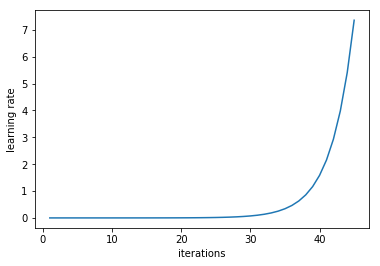

In [20]:
learner.sched.plot_lr()

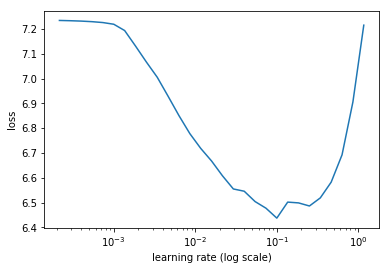

In [21]:
learner.sched.plot()

In [22]:
learner.fit(1e-3, 1, wds=1e-6)

epoch      trn_loss   val_loss                                                                                         
    0      5.688803   5.295673  



[array([5.29567])]

In [23]:
learner.fit(1e-3, 5, wds=1e-6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      5.12666    4.977058  
    1      4.998202   4.817785                                                                                         
    2      4.939106   4.794363                                                                                         
    3      4.881836   4.729558                                                                                         
    4      4.820913   4.677393                                                                                         
    5      4.775653   4.647077                                                                                         
    6      4.739502   4.634803                                                                                         
    7      4.710849   4.534355                                                                                         
    8  

[array([4.03157])]

In [24]:
learner.save_encoder('adam2_enc')

In [25]:
learner.fit(1e-3, 2, wds=1e-6, cycle_len=5, cycle_save_name='adam3_10')

epoch      trn_loss   val_loss                                                                                         
    0      4.178659   4.01914   
    1      4.159839   3.993429                                                                                         
    2      4.147677   3.984192                                                                                         
    3      4.13752    3.976264                                                                                         
    4      4.125748   3.974524                                                                                         
    5      4.131714   3.962364                                                                                         
    6      4.122435   3.947075                                                                                         
    7      4.107541   3.933145                                                                                         
    8  

[array([3.92711])]

In [26]:
learner.save_encoder('adam3_10_enc')

In [27]:
learner.fit(1e-3, 3, wds=1e-6, cycle_len=5, cycle_save_name='adam3_25')

epoch      trn_loss   val_loss                                                                                         
    0      4.07322    3.91568   
    1      4.066833   3.908705                                                                                         
    2      4.070822   3.898839                                                                                         
    3      4.058646   3.892055                                                                                         
    4      4.051196   3.885876                                                                                         
    5      4.04822    3.875123                                                                                         
    6      4.042858   3.862752                                                                                         
    7      4.027628   3.857687                                                                                         
    8  

[array([3.81265])]

In [28]:
learner.save_encoder('adam3_25_enc')

In [30]:
learner.fit(1e-3, 10, wds=1e-6, cycle_len=5, cycle_save_name='adam3_75')

epoch      trn_loss   val_loss                                                                                         
    0      3.978437   3.812648  
    1      3.974185   3.804595                                                                                         
    2      3.966544   3.792382                                                                                         
    3      3.958479   3.789141                                                                                         
    4      3.950547   3.787175                                                                                         
    5      3.950432   3.779466                                                                                         
    6      3.942114   3.776699                                                                                         
    7      3.92976    3.762214                                                                                         
    8  

[array([3.62462])]

In [31]:
learner.save_encoder('adam3_75_enc')

In [32]:
learner.fit(1e-3, 5, wds=1e-6, cycle_len=5, cycle_save_name='adam3_100')

epoch      trn_loss   val_loss                                                                                         
    0      3.754348   3.625409  
    1      3.740435   3.624799                                                                                         
    2      3.741626   3.618994                                                                                         
    3      3.749905   3.615592                                                                                         
    4      3.734734   3.613788                                                                                         
    5      3.741356   3.614287                                                                                         
    6      3.732443   3.611029                                                                                         
    7      3.729356   3.608173                                                                                         
    8  

[array([3.58319])]

In [33]:
learner.save_encoder('adam3_100_enc')

In [34]:
learner.fit(1e-3, 10, wds=1e-6, cycle_len=10, cycle_save_name='adam3_200')

epoch      trn_loss   val_loss                                                                                         
    0      3.678796   3.584266  
    1      3.685788   3.582912                                                                                         
    2      3.676908   3.576729                                                                                         
    3      3.675447   3.576769                                                                                         
    4      3.668058   3.574025                                                                                         
    5      3.65365    3.570879                                                                                         
    6      3.644165   3.570837                                                                                         
    7      3.645287   3.565569                                                                                         
    8  

    67     3.530028   3.521126                                                                                         
    68     3.513159   3.528753                                                                                         
    69     3.529771   3.522946                                                                                         
    70     3.542992   3.519819                                                                                         
    71     3.544266   3.517152                                                                                         
    72     3.536444   3.524752                                                                                         
    73     3.527029   3.519743                                                                                         
    74     3.522312   3.519403                                                                                         
    75     3.513475   3.523525          

[array([3.51763])]

In [35]:
learner.save_encoder('adam3_200_enc')

### Test

In [36]:
def proc_str(s): return TEXT.preprocess(TEXT.tokenize(s))
def num_str(s): return TEXT.numericalize([proc_str(s)])

In [37]:
m=learner.model

In [38]:
s="""service that is"""

In [39]:
def sample_model(m, s, l=50):
    t = num_str(s)
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(t)
    print('...', end='')

    for i in range(l):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        word = TEXT.vocab.itos[n.data[0]]
        print(word, end=' ')
        if word=='<eos>': break
        res,*_ = m(n[0].unsqueeze(0))

    m[0].bs=bs

In [40]:
sample_model(m,"flight was")

...cancelled flightled .   i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened 

In [41]:
sample_model(m,"people are")

...not working . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying 

In [42]:
sample_model(m,"food was")

...n't working . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying 

In [43]:
sample_model(m,"ride was ")

...a very long day . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 

In [44]:
sample_model(m,"checkin was ")

...cancelled flightled .   i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened 

In [45]:
sample_model(m,"check in was ")

...n't working . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying to get to a gate . i 'm not sure what happened . < eos > @united i 'm trying 

### Sentiment

In [60]:
TEXT = Pickle.load(open(f'{PATH}models/TEXTLOCAL.pkl','rb'))

In [61]:
from torchtext import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.sentiment if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)
        

In [62]:
TWEET_LABEL = data.Field(sequential=False)
splits = DataFrameDataset.splits(TEXT, TWEET_LABEL, train_df=df_trn, val_df=df_val, test_df=df_test)

#train_ds, val_ds, test_ds = DataFrameDataset.splits(
#  text_field=TEXT_FIELD, label_field=LABEL_FIELD, train_df=train_df, val_df=val_df, test_df=test_df)

In [63]:
md2 = TextData.from_splits(PATH, splits, bs)

In [64]:
#            dropout=0.3, dropouti=0.4, wdrop=0.3, dropoute=0.05, dropouth=0.2)

In [65]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_at_6(preds,targs):
    precision, recall, _ = precision_recall_curve(targs==2, preds[:,2])
    print(recall[precision>=0.6][0])
    return recall[precision>=0.6][0]

In [66]:
# dropout=0.4, dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.65, wdrop=0.5, dropoute=0.1, dropouth=0.3)
m3.data.test_dl.src.sort = False
m3.data.test_dl.src.sort_within_batch = False
m3.data.test_dl.src.shuffle = False
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.clip=25.

In [68]:
# this notebook has a mess of some things going under 'all/' others not, so a little hack here
# !ln -sf ../all/models/adam3_20_enc.h5 {PATH}models/adam3_20_enc.h5
# m3.load_encoder(f'../all/models/adam3_200_enc')
lrs=np.array([1e-4,1e-3,1e-3,1e-2,3e-2])

In [69]:
m3.freeze_to(-1)
m3.fit(lrs/2, 50, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 10, metrics=[accuracy], cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.583223   0.480726   0.846302  
    1      0.543773   0.614593   0.848951                                                                              
    2      0.525686   0.6005     0.846302                                                                              
    3      0.517787   0.441307   0.846302                                                                              
    4      0.523625   0.469441   0.846302                                                                              
    5      0.533002   0.495153   0.846302                                                                              
    6      0.519408   0.4665     0.846302                                                                              
    7      0.521557   0.564306   0.846302                                                                           

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.457214   0.367931   0.850213  
    1      0.409889   0.360693   0.85011                                                                               
    2      0.363726   0.318136   0.870667                                                                              
    3      0.351859   0.305403   0.875882                                                                              
    4      0.33383    0.292627   0.877924                                                                              
    5      0.318742   0.272327   0.894708                                                                              
    6      0.314524   0.25865    0.895998                                                                              
    7      0.302379   0.273806   0.894446                                                                           

[array([0.22052]), 0.9106088731462593]

In [70]:
prec_at_6(*m3.predict_with_targs())

0.8701923076923077


0.8701923076923077

In [71]:
m3.fit(lrs, 2, metrics=[accuracy], cycle_len=4, cycle_save_name='twt2')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.293429   0.221622   0.914485  
    1      0.275973   0.409686   0.843556                                                                              
    2      0.246802   0.200208   0.922053                                                                              
    3      0.251552   0.200446   0.923916                                                                              
    4      0.289702   0.247237   0.90429                                                                               
    5      0.247068   0.215495   0.924613                                                                              
    6      0.241371   0.185676   0.931319                                                                              
    7      0.226764   0.187045   0.929793                                                                           

[array([0.18705]), 0.9297934757952658]

In [72]:
prec_at_6(*m3.predict_with_targs())

0.9350961538461539


0.9350961538461539

In [73]:
m3.fit(lrs, 4, metrics=[accuracy], cycle_len=2, cycle_save_name='twt3')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.241381   0.210753   0.927614  
    1      0.222766   0.195378   0.927269                                                                              
    2      0.249513   0.215806   0.918308                                                                              
    3      0.216153   0.187724   0.928945                                                                              
    4      0.238234   0.183029   0.93316                                                                               
    5      0.210874   0.213885   0.926207                                                                              
    6      0.225888   0.278593   0.908229                                                                              
    7      0.210458   0.171082   0.936623                                                                           

[array([0.17108]), 0.9366229459939414]

In [74]:
prec_at_6(*m3.predict_with_targs())

0.9375


0.9375

In [75]:
m3.fit(lrs, 4, metrics=[accuracy], cycle_len=2, cycle_save_name='twt4')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.214923   0.18094    0.937202  
    1      0.196306   0.178792   0.935009                                                                              
    2      0.23358    0.246619   0.925675                                                                              
    3      0.193025   0.267457   0.934237                                                                              
    4      0.210598   0.276671   0.914141                                                                              
    5      0.198304   0.218365   0.929601                                                                              
    6      0.228355   0.238541   0.921654                                                                              
    7      0.179211   0.170985   0.939804                                                                           

[array([0.17099]), 0.9398036071006826]

In [76]:
prec_at_6(*m3.predict_with_targs())

0.9375


0.9375

In [77]:

# rnn_model = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
#           dropout=0.1, dropouti=0.65, wdrop=0.5, dropoute=0.1, dropouth=0.3)

# ...

# rnn_model.data.test_dl.src.sort = False
# rnn_model.data.test_dl.src.sort_within_batch = False
# rnn_model.data.test_dl.src.shuffle = False

probs = m3.predict(is_test=True)
preds = np.argmax(probs, axis=1)

pd.DataFrame({
    'id': df_test.index,
    'sentiment': [TWEET_LABEL.vocab.itos[p] for p in preds]}).to_csv('data/high-flyers/sub8.csv', index=False)
    
FileLink('data/high-flyers/sub8.csv')

C:\Users\nissan.dookeran\Documents\Github\fastai\courses\dl1\data\high-flyers\sub8.csv